# Comparing Quality of Samples of Multivariate Gaussians from Various Packages

In order to verify the validity of the data we have generated we will show that it coroborates with known theoretical results. This section shows that our random number generation is unbiased using two methods. The first will graph the random variable defined as the maxima of standard normal process minus the expected value of that process. The second will show 

In [1]:
import numpy as np
import pandas as pd

# For plotting data
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

%matplotlib inline

## Import Data
We need to import the following csv files to run statistical tests on them.
### C++ Generated Data
 - C++ MT19937 Data
 - Armadillo C++ Data using mvrnd()
 
### Python Generated Data
 - NumPy PCG64 Data
 - Jupyter PCG64 Data
 - (TO DO) SciPy QMC Multivariate Normal Data

For some strange reason, it seems that generating the data using Jupyter Notebooks gives us higher quality (i.e. lower correlation) data for our simulations. Thus, we are considering reading the data in from CSV's after we pre-generate it in Jupyter.

In [2]:
""" C++ MT19937 Generated Data """

File = r"~/FGF-manifold-simulator/Data/maxData_CPP_MT19937_n_10000_trials_20000.csv"

colnames=['max', 'exp'] 
data = pd.read_csv(File, names=colnames)

MaxData_CPP_MT19937 = np.array(data['max'])

In [3]:
""" C++ Armadillo Multivariate Normal Data """
File = r"~/FGF-manifold-simulator/Data/samples_CPP_armadillo_mvrnd_n_10000_trials_20000.csv"

colnames=[f'{i}' for i in range(10000)]
test_data = np.array(pd.read_csv(File, names=colnames))

MaxData_CPP_Armadillo = np.amax(test_data, axis=1)

In [4]:
""" Python PCG64 Jupyter Pre-Generated Data """

File = r"~/FGF-manifold-simulator/Data/samples_Jupyter_PCG64_n_40000_trials_20000.csv"

colnames=[f'{i}' for i in range(40000)]
Jupyter_Random_Data = np.array(pd.read_csv(File, names=colnames))

# need to format numpy array to have dimensions 10000 x 20000
Jupyter_Random_Data_Formatted = Jupyter_Random_Data[0:10000,0:20000]

# compute the maximum of sample vector (that is the max of each row)
# and store it in an array
MaxData_Jupyter_PCG64 = np.amax(Jupyter_Random_Data_Formatted, axis=1)

In [5]:
""" Python SciPy Quasi-Monte-Carlo (QMC) Multivariate Normal Pre-Generated Data """

File = r"~/FGF-manifold-simulator/Data/samples_SCIPY_MultivariateNormalQMC_n_10000_trials_20000.csv"

colnames=[f'{i}' for i in range(10000)]
test_data = np.array(pd.read_csv(File, names=colnames))

# compute the maximum of sample vector (that is the max of each row)
# and store it in an array
MaxData_SCIPY_MultivariateNormalQMC = np.amax(test_data, axis=1)

### Control Data
For good measure, we also generate some random vectors using this notebook's PCG64 generator. Using this data, we compute the maximum of each vector sampled and store these values in an array to compare their quality with the other data generated.

In [6]:
# PYTHON CONTROL DATA USING PCG64 - the modern one
n=10000
numTrials=20000

from numpy.random import default_rng
rng = default_rng()

def computeMn_PCG64(nval):
    vals=rng.standard_normal(nval)
    return np.max(vals)

def sampleMn_PCG64(nval, numTrials):
    Mn_array = []
    for j in range(numTrials):
        Mn_array.append(computeMn_PCG64(nval))
    return np.array(Mn_array)

MaxData_Jupyter_PCG64_Control = sampleMn_PCG64(n,20000)  

# 1. Convergence in Distribution
The first test we run verifies whether or not the sampled data agrees with the following fact:

If $(X_n)_n{\in\mathbb{N}}$ is a sequence of i.i.d standard normal random variables, then the variable
$M_n=\max_{0\leq j\leq n} X_j$ obeys the following limit law:
$$
    \mathbb{P}\left(a_n(M_n-b_n)\leq x\right) \xrightarrow{dist} \exp(-\exp(-x))
$$
where
$$
        a_n = \sqrt{2\log(n)} \quad b_n = \sqrt{2\log(n)} - \frac{1}{2}(2\log(n)^{-\frac{1}{2}}(\log(\log(n))+\log(4\pi))
$$

To test this, we will plot the maxima data that we collected from the various sources in histograms and check
which datasets converge in this manner.

In [8]:
# parameters for the pdf of limiting distribution of EM_n
n=10000

def a(n):
    return np.sqrt(2*np.log(n))

def b(n):
    return np.sqrt(2*np.log(n)) - 0.5*pow(2*np.log(n), -0.5)*(np.log(np.log(n))+np.log(4*np.pi))

def pdf(x):
    return np.exp(-x-np.exp(-x))

In [9]:
# shift data and scale accordingly by a(n) and b(n)
MaxData_CPP_MT19937_Scaled = a(n)*(MaxData_CPP_MT19937-b(n))
MaxData_CPP_Armadillo_Scaled = a(n)*(MaxData_CPP_Armadillo-b(n))
MaxData_Jupyter_PCG64_Scaled = a(n)*(MaxData_Jupyter_PCG64-b(n))
MaxData_Jupyter_PCG64_Control_Scaled = a(n)*(MaxData_Jupyter_PCG64_Control-b(n))
MaxData_SCIPY_MultivariateNormalQMC_Scaled = a(n)*(MaxData_SCIPY_MultivariateNormalQMC-b(n))

# create data for the X axis
X=np.arange(-5.0,10.0,0.001)

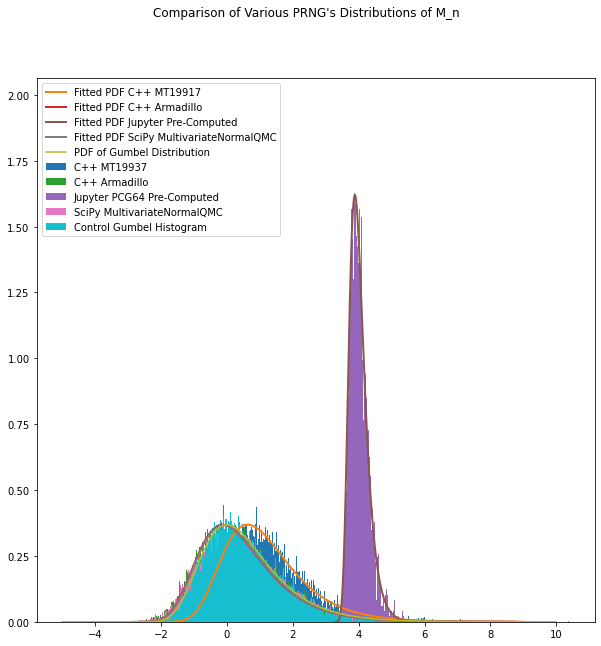

In [33]:
fig = plt.figure(figsize =(10,10))
ax1 = plt.subplot(111)
plt.suptitle("Comparison of Various PRNG's Distributions of M_n")

hist=True

# Plot the Histogram and Fitted PDF of the C++ MT19937 Data
(counts1, bins1) = np.histogram(MaxData_CPP_MT19937_Scaled, bins=500)
if hist:
    plt.hist(bins1[:-1], bins1, weights=counts1, density=True, label="C++ MT19937")
beta1 = np.std(MaxData_CPP_MT19937_Scaled) * np.sqrt(6) / np.pi
mu1 = np.mean(MaxData_CPP_MT19937_Scaled) - 0.57721*beta1
plt.plot(bins1, (1/beta1)*np.exp(-(bins1 - mu1)/beta1)
         * np.exp(-np.exp(-(bins1 - mu1)/beta1)),
         linewidth=2, label="Fitted PDF C++ MT19917")

# Plot the Histogram and Fitted PDF of the C++ Armadillo Data
(counts2, bins2) = np.histogram(MaxData_CPP_Armadillo_Scaled, bins=500)
if hist:
    plt.hist(bins2[:-1], bins2, weights=counts2, density=True, label="C++ Armadillo")
beta2 = np.std(MaxData_CPP_Armadillo_Scaled) * np.sqrt(6) / np.pi
mu2 = np.mean(MaxData_CPP_Armadillo_Scaled) - 0.57721*beta2
plt.plot(bins2, (1/beta2)*np.exp(-(bins2 - mu2)/beta2)
         * np.exp(-np.exp(-(bins2 - mu2)/beta2)),
         linewidth=2, label="Fitted PDF C++ Armadillo")

# Plot the Histogram and Fitted PDF of the C++ Generated Data
(counts4, bins4) = np.histogram(MaxData_Jupyter_PCG64, bins=500)
if hist:
    plt.hist(bins4[:-1], bins4, weights=counts1, density=True, label="Jupyter PCG64 Pre-Computed")
beta4 = np.std(MaxData_Jupyter_PCG64) * np.sqrt(6) / np.pi
mu4 = np.mean(MaxData_Jupyter_PCG64) - 0.57721*beta4
plt.plot(bins4, (1/beta4)*np.exp(-(bins4 - mu4)/beta4)
         * np.exp(-np.exp(-(bins4 - mu4)/beta4)),
         linewidth=2, label="Fitted PDF Jupyter Pre-Computed")

# Plot the Histogram and Fitted PDF of the SciPy MultiVariateNormal Data
(counts5, bins5) = np.histogram(MaxData_SCIPY_MultivariateNormalQMC_Scaled, bins=500)
if hist:
    plt.hist(bins5[:-1], bins5, weights=counts5, density=True, label="SciPy MultivariateNormalQMC")
beta5 = np.std(MaxData_SCIPY_MultivariateNormalQMC_Scaled) * np.sqrt(6) / np.pi
mu5 = np.mean(MaxData_SCIPY_MultivariateNormalQMC_Scaled) - 0.57721*beta5
plt.plot(bins5, (1/beta5)*np.exp(-(bins5 - mu5)/beta5)
         * np.exp(-np.exp(-(bins5 - mu5)/beta5)),
         linewidth=2, label="Fitted PDF SciPy MultivariateNormalQMC")

# Plot the Limit PDF of Gumbel and Histogram of Sample
plt.plot(X, pdf(X), label="PDF of Gumbel Distribution")
if hist:
    control_gumbel = np.random.gumbel(0, 1, 20000)
    count, bins = np.histogram(control_gumbel, 500)
    plt.hist(bins[:-1], bins, weights=count, density=True, label="Control Gumbel Histogram")

plt.legend(loc="upper left")
plt.show()

## Analysis of Different Random Number Engines:
We can see that the pre-saved Jupyter Data is incredibly skewed, which disagrees with the expectation. Moreover, we see that the C++ built in MT19937 algorithm seems to give correlated data even when it has different seeds, yielding a higher expected value of $M_n$ and hence $a_n(M_n-b_n)$. Moreover, the pre-written NumPy PCG64 data appears to not be written correctly, giving larger results.

**Takeaways: We see that SciPy and C++ Armadillo work well. For the forseeable future, we intend to use SciPy in our simulations on account of its ease of installation.**

Other Notes
- We would use Armadillo, but because we don't have root access on the HPC, any sort of installation of C++ packages is very time consuming. For the scope of this project, we intend to shift to Python
- I noticed in the code that trent sent me to generate the Jupyter Pre-Computed PCG64 data, the new line delimiters were different, which makes me wonder if perhaps this caused an error in data processing.
- Again, same thing with writing, reading, and parsing the NUMPY PCG64 Data. (UPDATE: For the time being I deleted this data since it was irrelevant).

Below, we include some other figures that highlight the convergence of the C++ Armadillo data to the theoretical distribution.

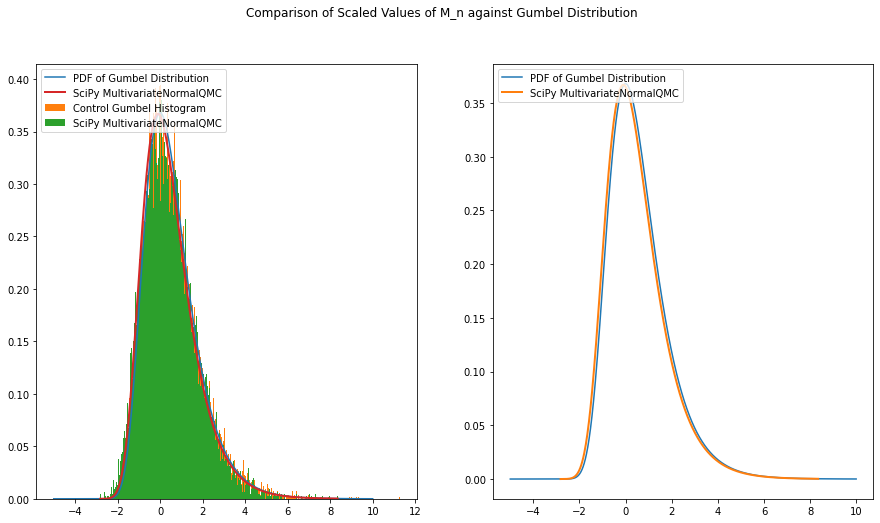

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Comparison of Scaled Values of M_n against Gumbel Distribution')

control = False

# Plot the Limit PDF of Gumbel and Histogram of Sample
ax1.plot(X, pdf(X), label="PDF of Gumbel Distribution")
ax2.plot(X, pdf(X), label="PDF of Gumbel Distribution")
control_gumbel = np.random.gumbel(0, 1, 20000)
count, bins = np.histogram(control_gumbel, 500)
ax1.hist(bins[:-1], bins, weights=count, density=True, label="Control Gumbel Histogram")

if control:
    # Plot the Histogram and Fitted PDF of the Control Jupyter PCG64 Randomly Generated Numbers
    (counts3, bins3) = np.histogram(MaxData_Jupyter_PCG64_Control_Scaled, bins=500)
    ax1.hist(bins3[:-1], bins3, weights=counts3, density=True, label="Control Jupyter PCG64")
    beta3 = np.std(MaxData_Jupyter_PCG64_Control_Scaled) * np.sqrt(6) / np.pi
    mu3 = np.mean(MaxData_Jupyter_PCG64_Control_Scaled) - 0.57721*beta3
    ax1.plot(bins3, (1/beta3)*np.exp(-(bins3 - mu3)/beta3)
             * np.exp(-np.exp(-(bins3 - mu3)/beta3)),
             linewidth=2, label="Fitted PDF Control Jupyter PCG64")
    ax2.plot(bins3, (1/beta3)*np.exp(-(bins3 - mu3)/beta3)
             * np.exp(-np.exp(-(bins3 - mu3)/beta3)),
             linewidth=2, label="Fitted PDF Control Jupyter PCG64")

# Plot the Histogram and Fitted PDF of the Control Jupyter PCG64 Randomly Generated Numbers
(counts4, bins4) = np.histogram(MaxData_SCIPY_MultivariateNormalQMC_Scaled, bins=500)
ax1.hist(bins4[:-1], bins4, weights=counts4, density=True, label="SciPy MultivariateNormalQMC")
beta4 = np.std(MaxData_SCIPY_MultivariateNormalQMC_Scaled) * np.sqrt(6) / np.pi
mu4 = np.mean(MaxData_SCIPY_MultivariateNormalQMC_Scaled) - 0.57721*beta4
ax1.plot(bins4, (1/beta4)*np.exp(-(bins4 - mu4)/beta4)
         * np.exp(-np.exp(-(bins4 - mu4)/beta4)),
         linewidth=2, label="SciPy MultivariateNormalQMC")
ax2.plot(bins4, (1/beta4)*np.exp(-(bins4 - mu4)/beta4)
         * np.exp(-np.exp(-(bins4 - mu4)/beta4)),
         linewidth=2, label="SciPy MultivariateNormalQMC")

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
plt.show()

# 2. Expected Value as n Increases
We know from Leadbetter et. al. that if $(X_n)_{n\in\mathbb{N}}$ is a sequence of $\mathcal{N}(0,1)$
i.i.d variables and $M_n=\max_{0\leq j\leq n}X_j$, then
$$
\mathbb{E}M_n \approx \sqrt(2\log(n)-\frac{1}{2}(2\log(n))^{-\frac{1}{2}}(\log\log(n)+\log(4\pi))
$$
Using this, we can plot and compare the empirical value of $\mathbb{E}M_n$ against the known
theoretical value. As it turns out, the empirical data that we generated agrees with the theory.

In [18]:
File = r'~/FGF-manifold-simulator/Data/empiricalMeans_SCIPY_MultivariateNormalQMC_nstart_100_n_stop_21000_n_step_50.csv'

colnames=['exp'] 
data = pd.read_csv(File, names=colnames)

empirical_means_SCIPY_MultivariateNormalQMC = np.array(data['exp'])

n_start=100
n_stop=21000
n_step=50
n_vals = np.arange(start = n_start, stop = n_stop+n_step, step = n_step)

In [23]:
# Computing the Python EMn data
def sample_EMn(numTrials):
    EMn_array = []
    for n in n_vals:
        EMn_array.append(
            np.mean(sampleMn_PCG64(n, numTrials))
        )
    return EMn_array

Control_Exp_Data_PCG64 = sample_EMn(4000)

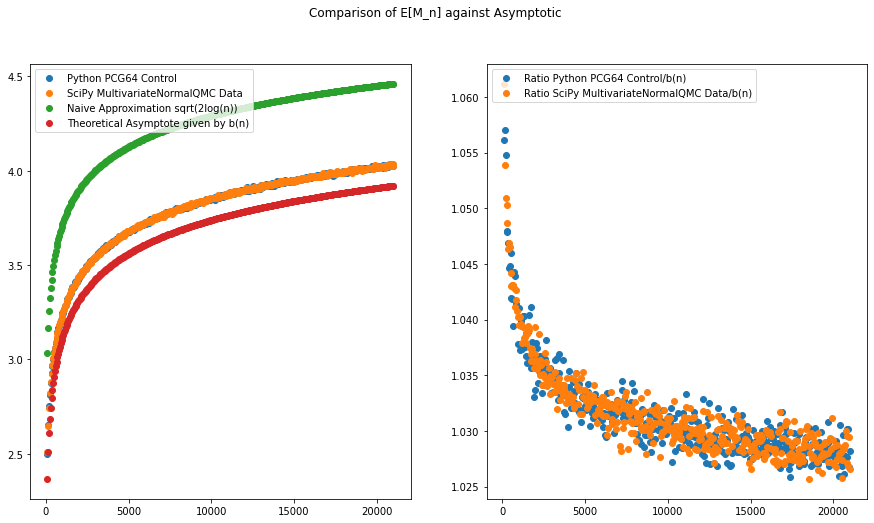

In [31]:
plot_control=True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Comparison of E[M_n] against Asymptotic')

if plot_control:
    ax1.scatter(n_vals,Control_Exp_Data_PCG64, label="Python PCG64 Control")
ax1.scatter(n_vals, empirical_means_SCIPY_MultivariateNormalQMC, label="SciPy MultivariateNormalQMC Data")
ax1.scatter(n_vals, np.sqrt(2*np.log(n_vals)), label="Naive Approximation sqrt(2log(n))")
ax1.scatter(n_vals, b(n_vals), label="Theoretical Asymptote given by b(n)")
ax1.legend(loc="upper left")

if plot_control:
    ax2.scatter(n_vals,Control_Exp_Data_PCG64/b(n_vals), label="Ratio Python PCG64 Control/b(n)")
ax2.scatter(n_vals, empirical_means_SCIPY_MultivariateNormalQMC/b(n_vals), label="Ratio SciPy MultivariateNormalQMC Data/b(n)")
ax2.legend(loc="upper left")

plt.show()

## Analysis
- The asymptotic $\mathbb{E}M_n\sim b(n)$ is not an equality - it is up to a scalar multiple. Perhaps this means we should verify that when we divide it, it gets constant.
- SciPy once again gives us very reliable data, even with the better asymptotic.

# 3. Distribution of Maxima of Brownian Bridge

Since the DFGF of parameter $s=\frac{1}{2}$ converges in distribution (in the sense of stochastic processes) to the FGF of parameter $=\frac{1}{2}$. We know that with Dirichlet boundary conditions, the FGF is a Brownian Bridge on 

In [ ]:
# Distribution of Maximum
File = r'~/FGF-manifold-simulator/data/expected_maxima_s_0.5_n_4096_numTrials_10000.csv'
colnames = ['samples']
data = pd.read_csv(File, name=colnames)

empirical_mean_BB=np.array(data['samples'])

# 4. Expected Value of Maxima of Brownian Bridge vs. n

In [ ]:
# Expected Maximum
File = r'~/FGF-manifold-simulator/data/expected_maxima_s_0.5_n_1000-20000_numTrials_4000.csv'
colnames = ['expvals']
data = pd.read_csv(File, name=colnames)

empirical_mean_BB=np.array(data['expvals'])